In [4]:
#!unzip sample_submission.csv.zip 
#!unzip store.csv.zip
#!unzip test.csv.zip 
#!unzip train.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  store.csv.zip
  inflating: store.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [125]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 24, 6

import statsmodels.api as sm

In [173]:
# reference: https://logics-of-blue.com/wp-content/uploads/2017/05/python-state-space-models.html

In [126]:
df = pd.read_csv("train.csv", parse_dates = True, index_col = 'Date')
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [127]:
data = df['Sales'].groupby('Date').sum()
data.head()

Date
2013-01-01      97235
2013-01-02    6949829
2013-01-03    6347820
2013-01-04    6638954
2013-01-05    5951593
Name: Sales, dtype: int64

In [128]:
thres = '2014-12-31'
train = data[data.index <= thres]
test = data[data.index > thres]

In [129]:
train.shape

(730,)

In [130]:
test.shape

(212,)

In [131]:
test.tail()

Date
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, dtype: int64

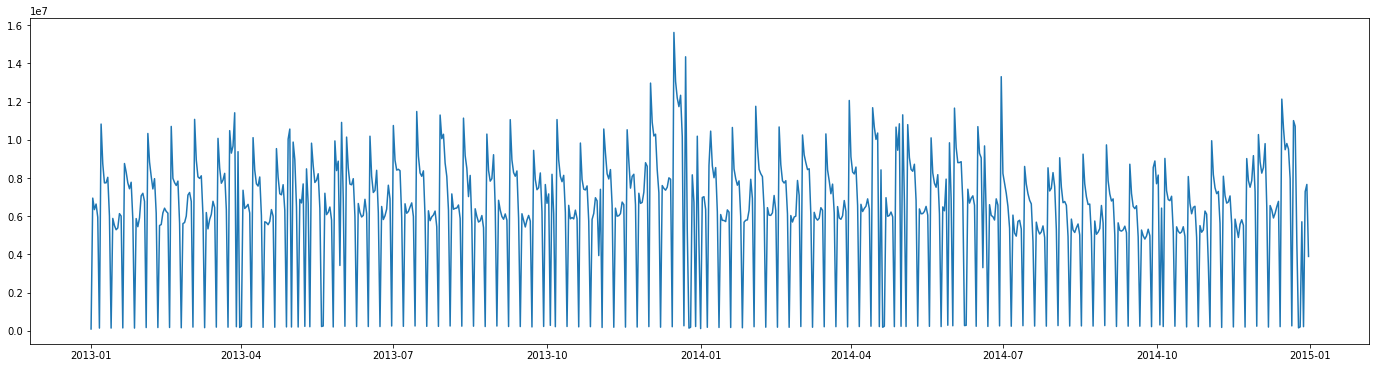

In [132]:
plt.plot(train)

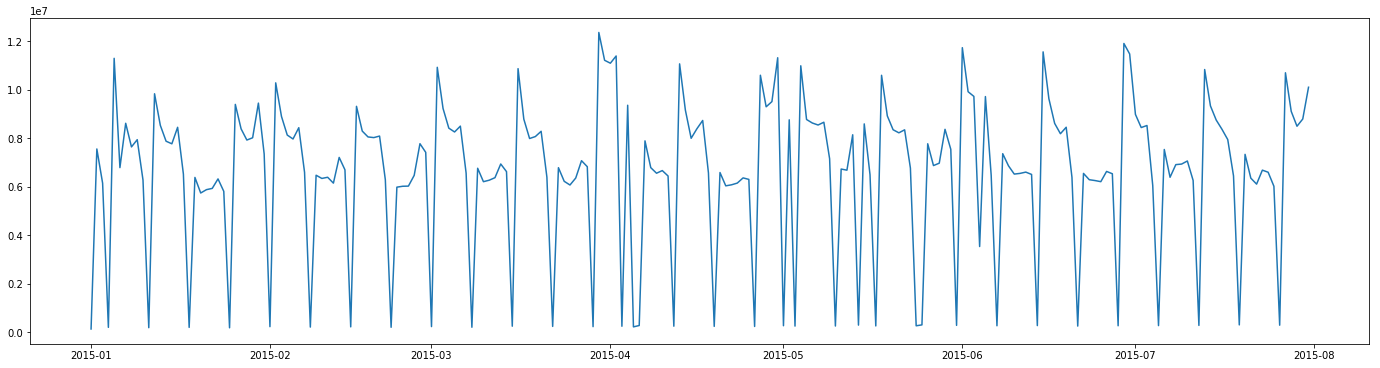

In [133]:
plt.plot(test)

# Mean absolute percentage error (MAPE)

$$MAPE=\frac{1}{n}\sum_{t=1}^{n}\left |\frac{y_t - \hat{y}_t}{y_t}\right|$$

# Root Mean Square Percentage Error (RMSPE)

$$\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{t=1}^{n} \left(\frac{y_t - \hat{y}_t}{y_t}\right)^2}$$
where $y_t$ is the actual value and $\hat{y}_t$ is the forecast value.

In [165]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [166]:
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))

# State space models

## Local level model

                        Unobserved Components Results                         
Dep. Variable:                  Sales   No. Observations:                  730
Model:                    local level   Log Likelihood              -11978.430
Date:                Sun, 25 Aug 2019   AIC                          23960.860
Time:                        06:52:51   BIC                          23970.043
Sample:                    01-01-2013   HQIC                         23964.403
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  9.194e+12   4.58e+11     20.079      0.000     8.3e+12    1.01e+13
sigma2.level       2.67e+11   8.05e+10      3.317      0.001    1.09e+11    4.25e+11
Ljung-Box (Q):              

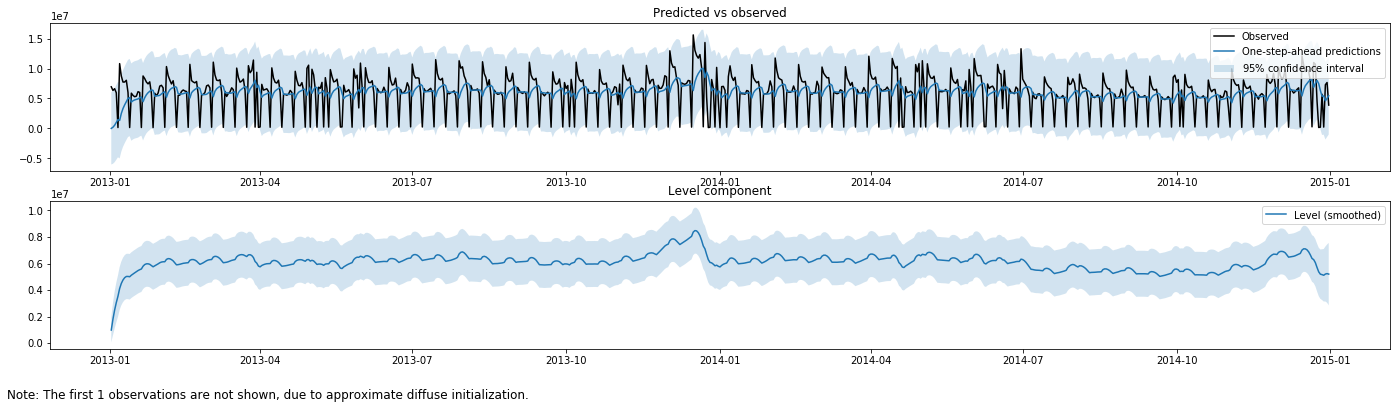

In [134]:
mod_local_level = sm.tsa.UnobservedComponents(train, 'local level', freq='D')

res_local_level = mod_local_level.fit()

print(res_local_level.summary())
res_local_level.plot_components();

MAPE =  3.87523020119
RMSPE =  8.9466379522


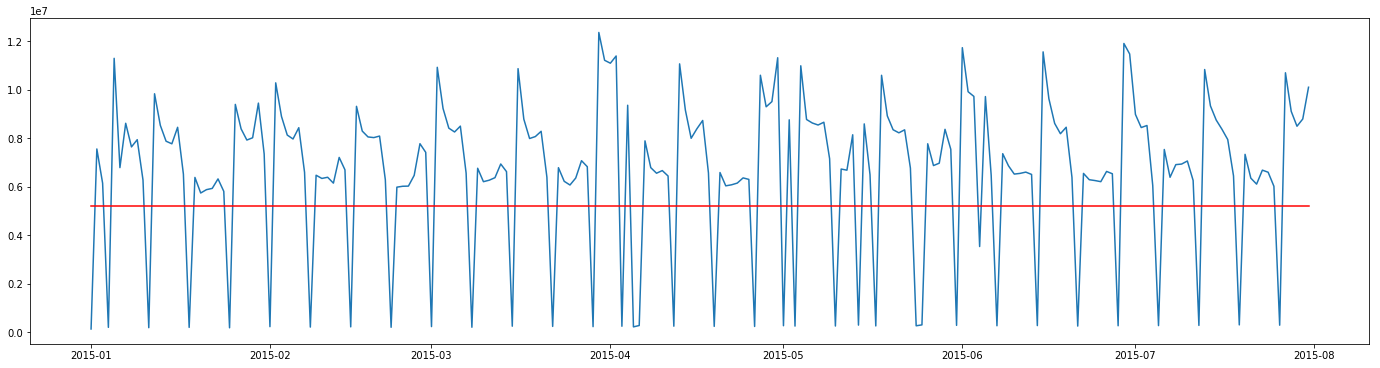

In [167]:
pred_local_level = res_local_level.predict('2015-01-01', '2015-07-31')
plt.plot(test)
plt.plot(pred_local_level, 'r');
print("MAPE = ", mape(test, pred_local_level))
print("RMSPE = ", rmspe(test, pred_local_level))

## Local linear trend model

                        Unobserved Components Results                         
Dep. Variable:                  Sales   No. Observations:                  730
Model:             local linear trend   Log Likelihood              -12083.312
Date:                Sun, 25 Aug 2019   AIC                          24172.625
Time:                        06:59:07   BIC                          24186.396
Sample:                    01-01-2013   HQIC                         24177.938
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  9.194e+12   5.71e+11     16.103      0.000    8.08e+12    1.03e+13
sigma2.level      7.563e+09   4.48e+11      0.017      0.987   -8.71e+11    8.86e+11
sigma2.trend      2.365e+11 

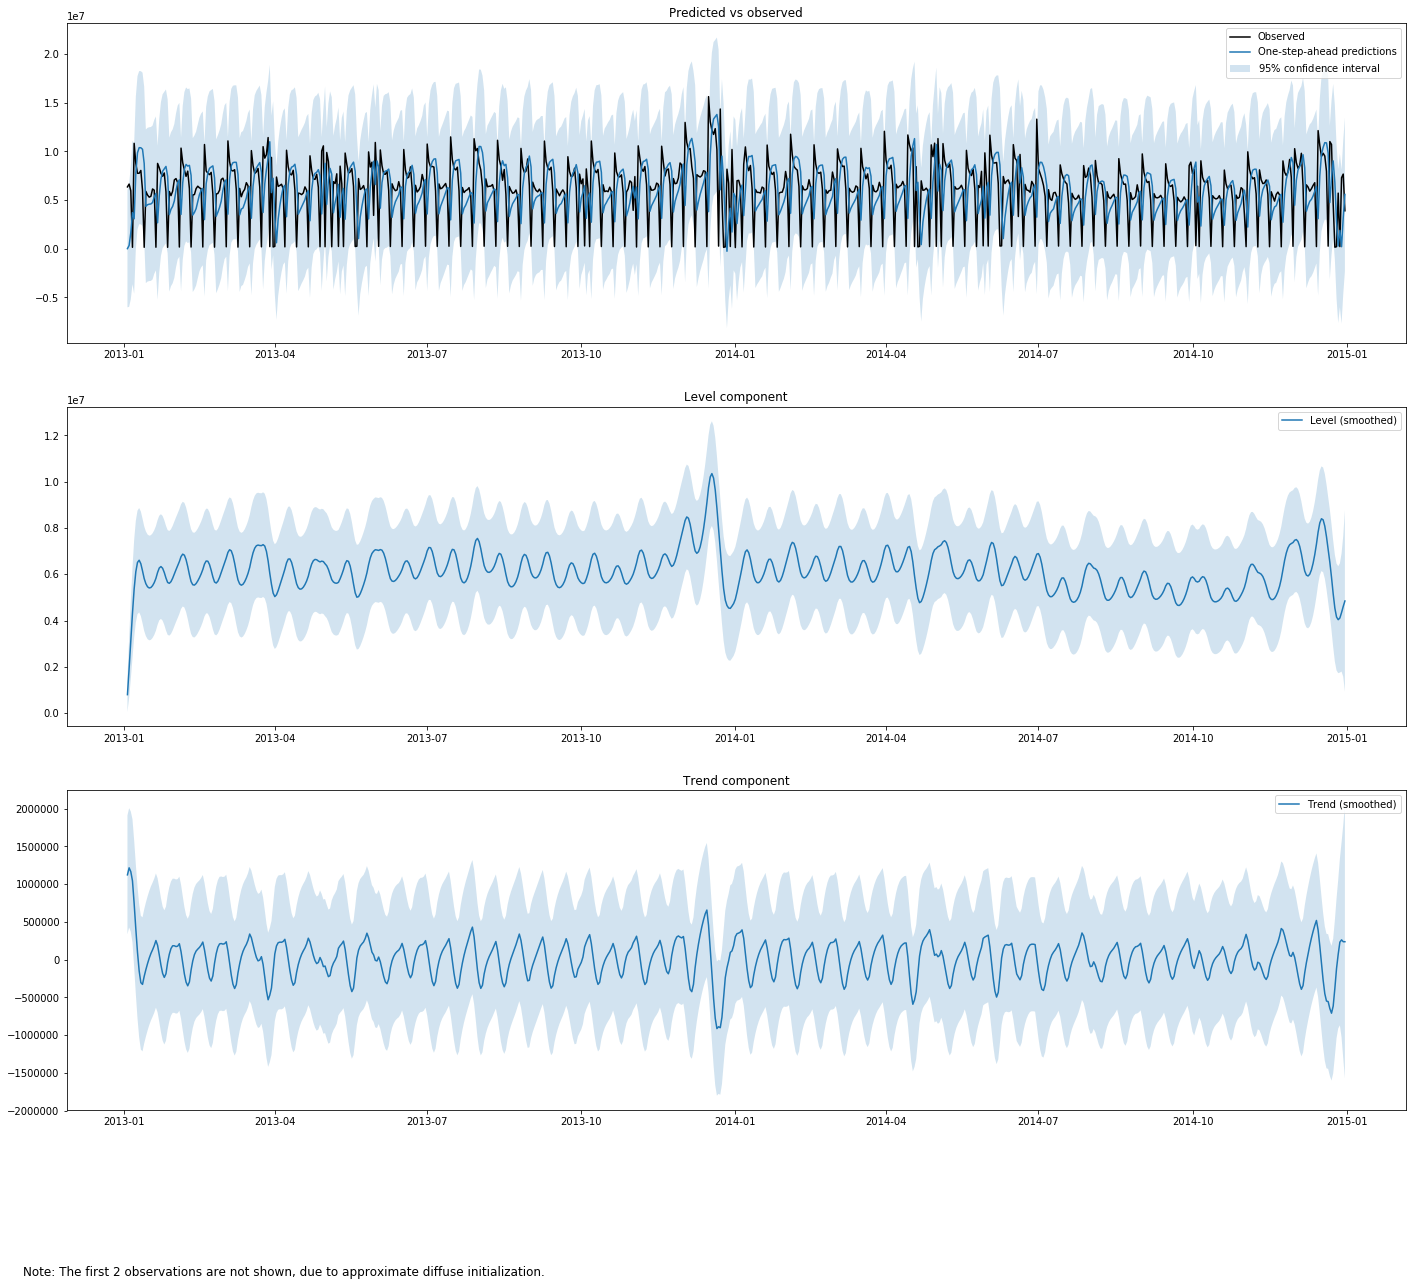

In [142]:
mod_trend = sm.tsa.UnobservedComponents(train, 'local linear trend', freq='D')

res_trend = mod_trend.fit()

print(res_trend.summary())
plt.rcParams['figure.figsize'] = 24, 20
res_trend.plot_components();

MAPE =  22.2982769314
RMSPE =  51.6434591192


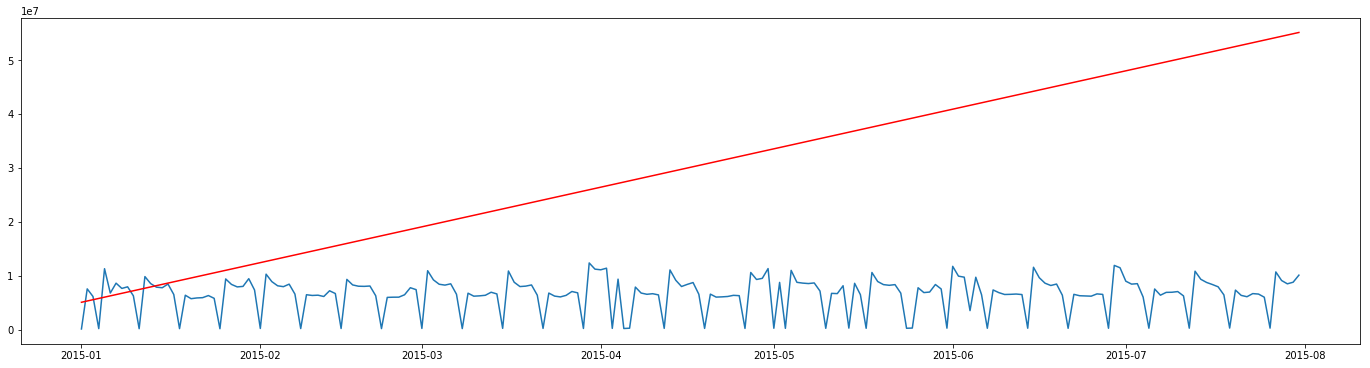

In [169]:
pred_trend = res_trend.predict('2015-01-01', '2015-07-31')
plt.rcParams['figure.figsize'] = 24, 6
plt.plot(test)
plt.plot(pred_trend, 'r');
print("MAPE = ", mape(test, pred_trend))
print("RMSPE = ", rmspe(test, pred_trend))

## Seasonal local level model

                            Unobserved Components Results                            
Dep. Variable:                         Sales   No. Observations:                  730
Model:                           local level   Log Likelihood              -12033.629
                   + stochastic seasonal(12)   AIC                          24073.258
Date:                       Sun, 25 Aug 2019   BIC                          24086.987
Time:                               07:02:37   HQIC                         24078.559
Sample:                           01-01-2013                                         
                                - 12-31-2014                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  9.194e+12   1.92e+12      4.800      0

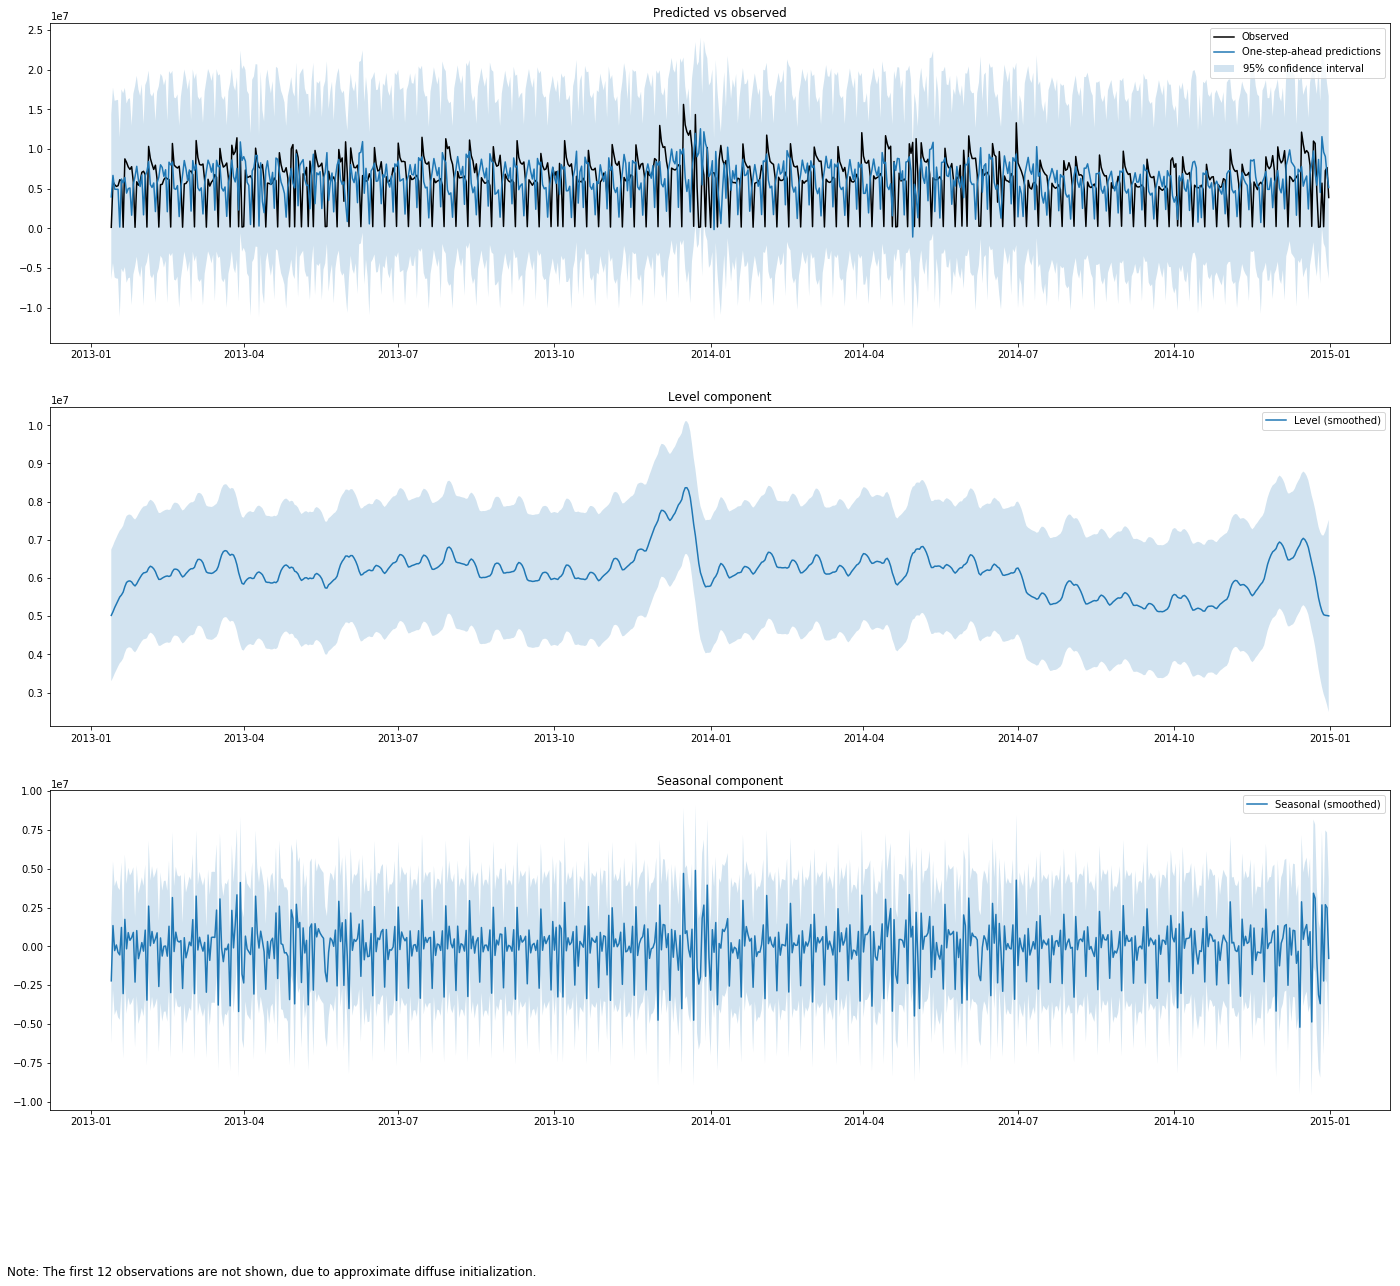

In [145]:
mod_season_local_level = sm.tsa.UnobservedComponents(train, 'local level', freq='D', seasonal=12)

res_season_local_level = mod_season_local_level.fit()

print(res_season_local_level.summary())
plt.rcParams['figure.figsize'] = 24, 20
res_season_local_level.plot_components();

MAPE =  4.02980179181
RMSPE =  10.3780371144


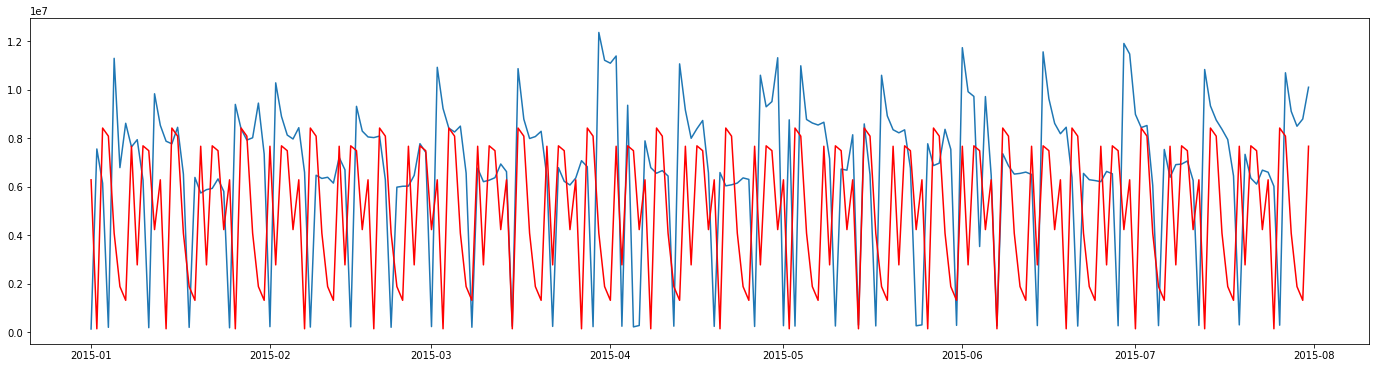

In [170]:
pred_season_local_level = res_season_local_level.predict('2015-01-01', '2015-07-31')
plt.rcParams['figure.figsize'] = 24, 6
plt.plot(test)
plt.plot(pred_season_local_level, 'r');
print("MAPE = ", mape(test, pred_season_local_level))
print("RMSPE = ", rmspe(test, pred_season_local_level))

## Seasonal local linear trend model

                            Unobserved Components Results                            
Dep. Variable:                         Sales   No. Observations:                  730
Model:                    local linear trend   Log Likelihood              -12143.680
                   + stochastic seasonal(12)   AIC                          24295.361
Date:                       Sun, 25 Aug 2019   BIC                          24313.661
Time:                               07:30:15   HQIC                         24302.427
Sample:                           01-01-2013                                         
                                - 12-31-2014                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  9.194e+12   4.12e+12      2.231      0

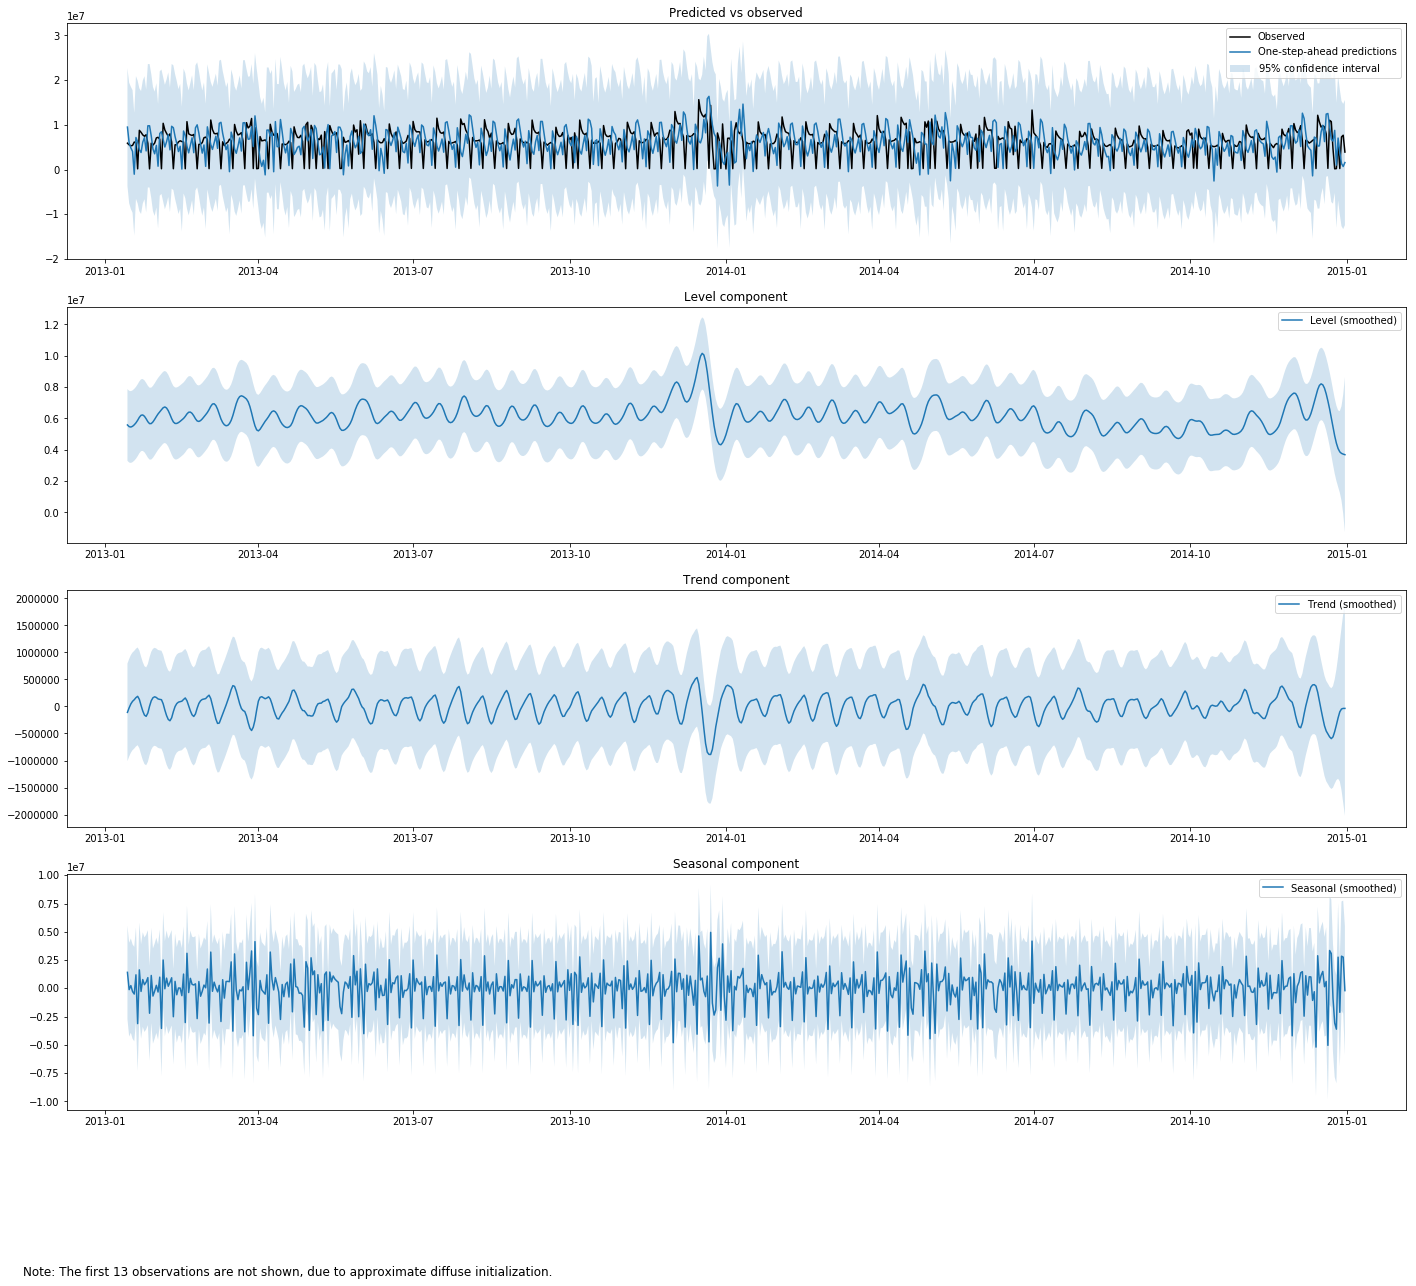

In [159]:
mod_season_trend = sm.tsa.UnobservedComponents(train, 'local linear trend', freq='D', seasonal=12)

res_season_trend = mod_season_trend.fit()

print(res_season_trend.summary())
plt.rcParams['figure.figsize'] = 24, 20
res_season_trend.plot_components();

MAPE =  4.26972951074
RMSPE =  10.0855657891


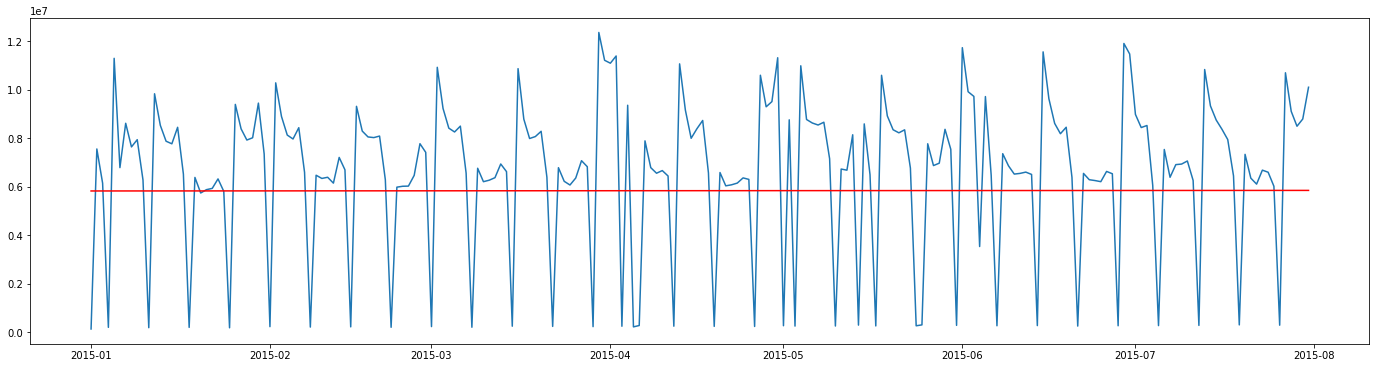

In [171]:
pred_season_trend = res_season_trend.predict('2015-01-01', '2015-07-31')
plt.rcParams['figure.figsize'] = 24, 6
plt.plot(test)
plt.plot(pred_season_trend, 'r');
print("MAPE = ", mape(test, pred_season_trend))
print("RMSPE = ", rmspe(test, pred_season_trend))

Optimization terminated successfully.
         Current function value: 16.103554
         Iterations: 299
         Function evaluations: 553
Optimization terminated successfully.
         Current function value: 16.103554
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                         Sales   No. Observations:                  730
Model:                    local linear trend   Log Likelihood              -11755.594
                   + stochastic seasonal(12)   AIC                          23519.188
Date:                       Sun, 25 Aug 2019   BIC                          23537.489
Time:                               07:30:29   HQIC                         23526.255
Sample:                           01-01-2013                                         
                                - 12-31-2014                                         
C

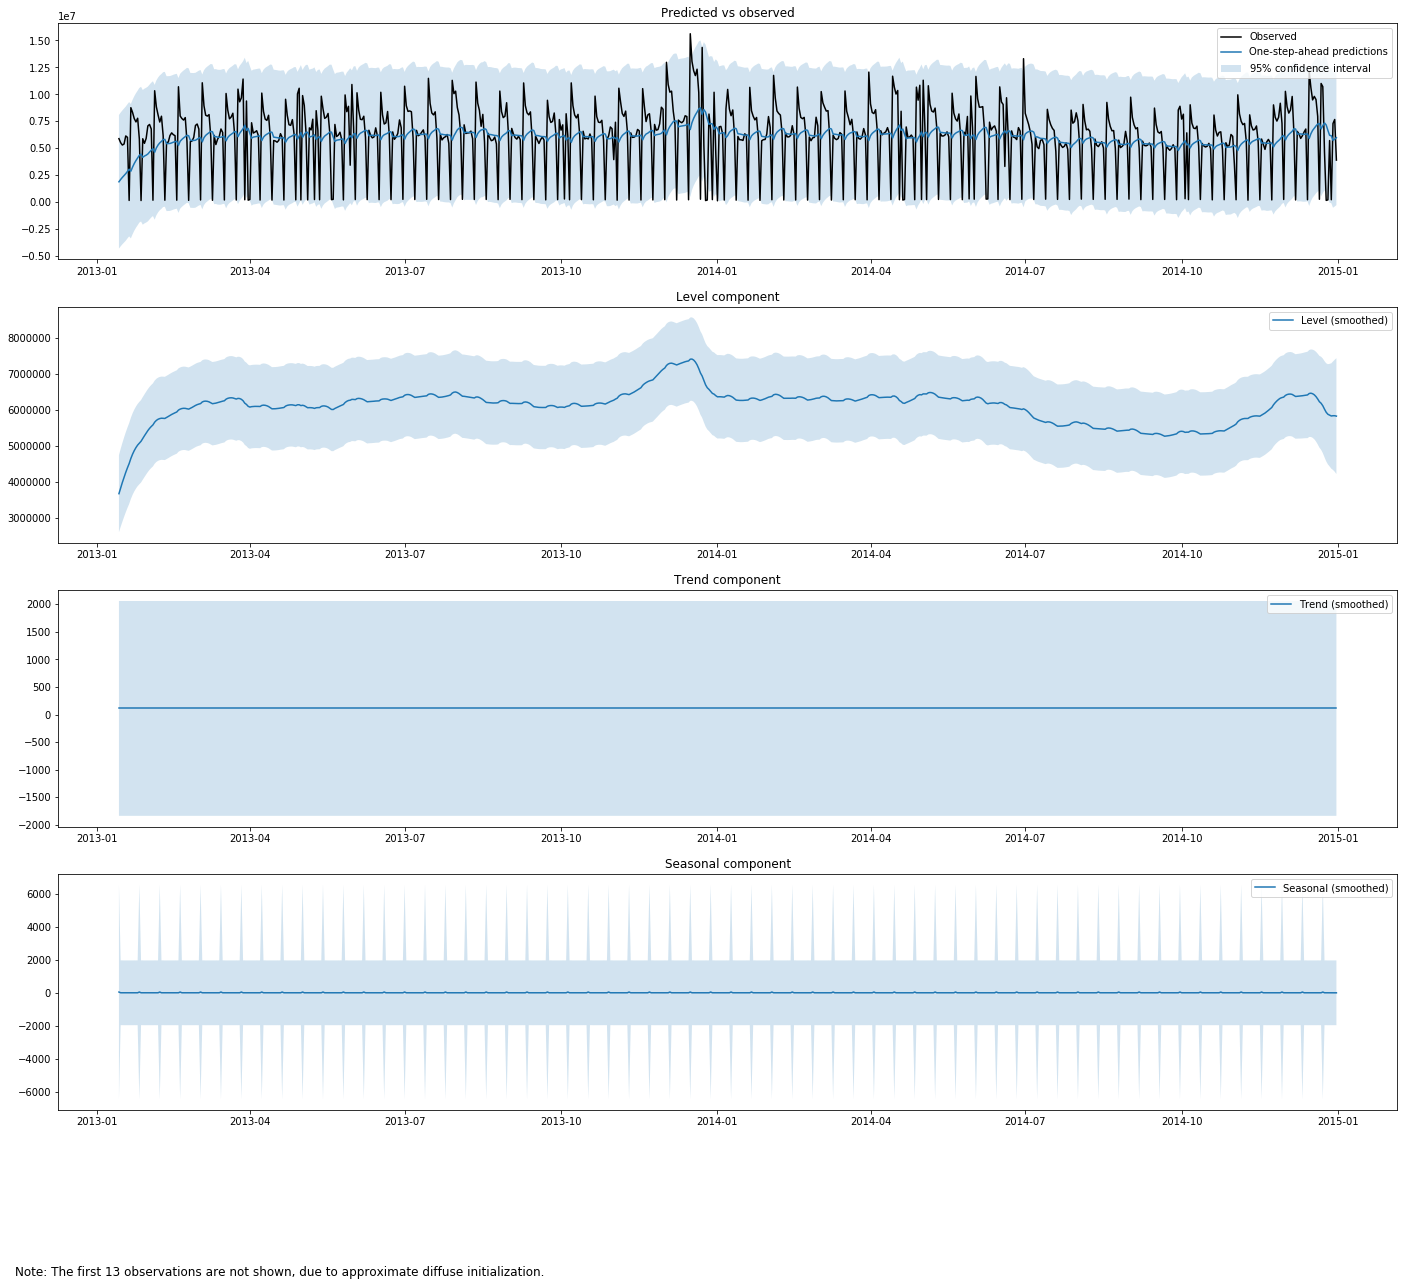

In [161]:
mod_season_trend = sm.tsa.UnobservedComponents(train, 'local linear trend', freq='D', seasonal=12)

#res_season_trend = mod_season_trend.fit()
res_season_trend = mod_season_trend.fit(
    method='bfgs',
    maxiter=500,
    start_params=mod_season_trend.fit(method='nm', maxiter=500).params
)

print(res_season_trend.summary())
plt.rcParams['figure.figsize'] = 24, 20
res_season_trend.plot_components();

MAPE =  4.26972951074
RMSPE =  10.0855657891


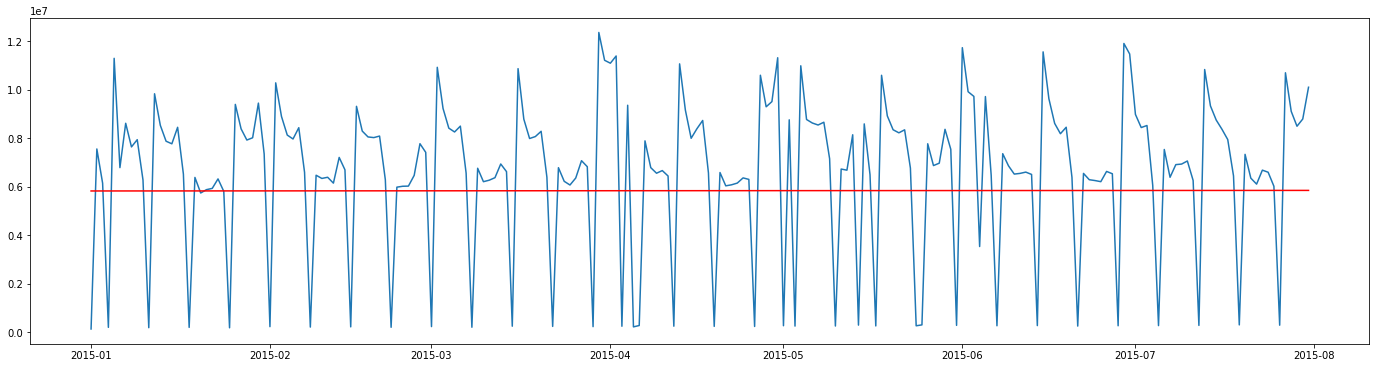

In [172]:
pred_season_trend = res_season_trend.predict('2015-01-01', '2015-07-31')
plt.rcParams['figure.figsize'] = 24, 6
plt.plot(test)
plt.plot(pred_season_trend, 'r');
print("MAPE = ", mape(test, pred_season_trend))
print("RMSPE = ", rmspe(test, pred_season_trend))